In [1]:
import time
import yaml
import torch
from utils import *
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from astropy.io import fits
from model.BrownianBridge.base.modules.diffusionmodules.openaimodel import UNetModel
from model.BrownianBridge.BrownianBridgeModel import BrownianBridgeModel as BBDM

torch.xpu.empty_cache()
%matplotlib widget

Mean: 0.0062535687961825905  STD: 0.0306770344598794


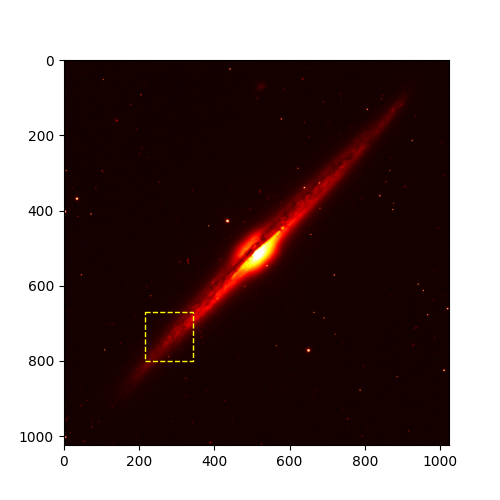

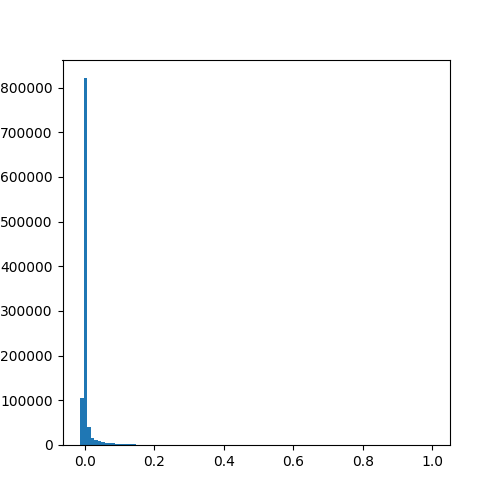

In [2]:
x = './imgs/4565_sdss.fits'
y = './imgs/4565_ps.fits'
d = np.arcsinh(fixnan(get_d(x))/.075)
d /= d.max()


ddd1 = np.flip(np.nan_to_num(fixnan(get_d(x))), axis=0)
dd1 = rescale(change_order(ddd1), 1024)
dd1 -= np.median(dd1)
dd1 = add_transient(dd1, x=280, y=735, flux=5, fwhm=3)
dd1 = np.arcsinh(dd1)
d1 = dd1 / dd1.max()

image_d(d1, cmap='hot', contrast=.001, mx=280, my=735, mw=128)
hist(d1)

In [3]:
def run(x = './imgs/4565_sdss.fits', 
        y = './imgs/4565_ps.fits',  
        name='test', 
        config_f="./configs/astro_config.yaml", 
        mx=280, my=735, mxw=128, myw=128, 
        transient=False, flux=10
       ):
    """Trains BBDM model to translate Y image into X
        Parameters:
            x              -- X image path 
            y              -- Y image path 
            name           -- image name
            config_f       -- config file path 
            mx             -- mask center x-coord
            my             -- mask center y-coord
            mxw            -- mask x width
            mxy            -- mask y width
            transient      -- whether to put test transient in the center of a mask
            flux           -- test transient flux
    """
    
    # config file
    with open(config_f, "r") as file:
        config = dict2namespace(yaml.load(file, Loader=yaml.FullLoader)) 

    im_size = config.data.dataset_config.image_size
    batch_size = config.data.train.batch_size
    tile_size = config.data.train.tile_size
    n_tiles = int((im_size / tile_size)**2)
    
    # inpainting mask
    m = np.ones((im_size, im_size))
    m[my - myw // 2:my + myw // 2, mx - mxw // 2:mx + mxw // 2] = 0
    
    # target image
    ddd1 = np.flip(np.nan_to_num(fixnan(get_d(x))), axis=0)
    dd1 = rescale(change_order(ddd1), im_size)
    dd1 -= np.median(dd1)

    if transient:
        dd1 = add_transient(dd1, x=mx, y=my, flux=flux, fwhm=5)
    else:
        pass

    dd1 = np.arcsinh(dd1)
    d1 = dd1 / dd1.max()

    gt = d1.copy()  # ground truth image
    gtm = gt * m    # masked ground truth image
    
    # reference image
    dd2 = np.flip(np.nan_to_num(get_d(y)), axis=0)
    dd2 /= dd2.max()
    d2 = rescale(change_order(dd2), (im_size, im_size))

    # images
    xx = np2torch(gtm.astype(float).copy()).to(config.training.device).float()
    yy = np2torch(d2.astype(float).copy()).to(config.training.device).float()
    mm = np2torch(m.astype(float).copy()).to(config.training.device).float()
    orig_shape = xx.shape
    
    # tiling
    x_tiles = get_tiles(xx, config.data.train.tile_size)
    y_tiles = get_tiles(yy, config.data.train.tile_size)
    m_tiles = get_tiles(mm, config.data.train.tile_size)
    
    # model
    model = BBDM(config.model).to(config.training.device)
    losses = []
    count_params(model)

    # gt contrast
    zscale = ZScaleInterval(contrast=.02)
    z1, z2 = zscale.get_limits(gt)
    
    # ground truth image
    save_img(gt, './checks/' + str(name) + '/gt.png', 
             mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
    # masked image
    save_img(gtm, './checks/' + str(name) + '/gtm.png', 
             mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
    # condition image
    save_img(d2, './checks/' + str(name) + '/condition.png', 
               contrast=.02)
    
    n_timesteps = config.training.n_steps                   # nuber of diffusion timesteps
    n_epochs = config.training.n_epochs                     # Total number of epochs
    decay_start_epoch = config.training.decay_start_epoch   # Decay starts after 100 epochs
    
    def custom_decay(step):
        if step < decay_start_epoch:
            return 1.0  # Maintain initial learning rate
        else:
            # Linear decay
            decay_factor = (n_epochs - step) / (n_epochs - decay_start_epoch)
            return max(decay_factor, 0.0)  # Ensure non-negative factor
    
    # Prepare the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    
    # Initialize the learning rate scheduler
    lr_scheduler = LambdaLR(optimizer, lr_lambda=custom_decay)
    
    start_time = time.time()
    
    for epoch in range(n_epochs):

        # Randomly shuffle tile indices for better training
        indices = torch.randperm(n_tiles)
        batch_indices = indices[:batch_size]  # Pick N random tiles

        x_batch = x_tiles[batch_indices]
        y_batch = y_tiles[batch_indices]
        m_batch = m_tiles[batch_indices]
        
        t = torch.randint(0, n_timesteps, (1,), device=config.training.device)  # Random timestep
        
        # Calculate loss (MSE)
        loss = model.p_losses(x0=x_batch, y=y_batch, context=None, t=t, m=m_batch)[0]
        losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Time: {np.round(time.time() - start_time, 2)}, Lr: {optimizer.param_groups[0]['lr']}")
    
        # saving intermediate images
        interim_epoch = config.training.interim_epoch
        
        if epoch % interim_epoch == 0 and epoch != 0:

            start = 0
            tiles_list = []
            
            for i in range(int(len(y_tiles) // batch_size)):   # [0:5], [5:9], [9:13], [13:17]
                
                end = start + batch_size
                y_batch = y_tiles[start:end]
                
                out = model.sample(y_batch)   
                tiles_list.append(out)    

                start = end

            out_tiles = torch.cat(tiles_list)
            final_tiles = torch.unsqueeze(out_tiles, 0)
            array_data = torch2np(merge_tiles(final_tiles, orig_shape, tile_size))[:, :, 0]
            
            # Save the image to a PNG file            
            save_img(array_data, './checks/' + str(name) + '/' + str(epoch) + '_image.png', 
                     mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        # Update learning rate
        lr_scheduler.step()
        
    return model, losses, array_data, gt

In [1]:
model, losses, rec, gt = run(x='./imgs/4565_sdss.fits', 
                         y='./imgs/4565_ps.fits',
                         name=4565, 
                         config_f="./configs/astro_config.yaml",
                         mx=280, my=735, 
                         mxw=128, myw=128)   